<h3>Importing Libraries</h3>

In [27]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.regularizers import l2,l1_l2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import keras.preprocessing.image as image
from tensorflow.keras.applications import VGG16

In [3]:
tf.__version__

'2.13.0'

<h3>Data Preprocessing</h3>

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2, horizontal_flip=True,vertical_flip=True,
                                   fill_mode="nearest", rotation_range=10,brightness_range=[0.8,1.2],width_shift_range=0.1, height_shift_range=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)
Train=train_datagen.flow_from_directory('dataset/train',target_size=(64,64),batch_size=32,class_mode='binary')
Test=test_datagen.flow_from_directory('dataset/test',target_size=(64,64),batch_size=32,class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


<h3>Model Creation</h3>

In [20]:
#Defining the CNN
cnn=Sequential()

#adding first convolutional layer
cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=[64,64,3]))

#adding first pooling layer
cnn.add(MaxPool2D(pool_size=(2,2),strides=2))

#adding 2nd convolutional layer
cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2),strides=2))

cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2),strides=2))

cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2),strides=2))

#adding flattening layer
cnn.add(Flatten())

#tried leaky relu but it was not giving good results
#adding hidden layer
cnn.add(Dense(128,activation='relu',kernel_regularizer=l2(0.01)))
# cnn.add(Dense(128,activation='relu',kernel_regularizer=l2(0.01)))

cnn.add(Dropout(0.15,seed=42))

#adding the output layer
cnn.add(Dense(1,activation='sigmoid'))

In [21]:

cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

<h3>Training Model</h3>

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
checkpoint=ModelCheckpoint('best_model v6.h5',monitor='val_loss',mode='min',save_best_only=True,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history=cnn.fit(x=Train,validation_data=Test,epochs=70,callbacks=[early_stopping,checkpoint,reduce_lr],verbose=1)

Epoch 1/70
250/250 [==============================] - ETA: 0s - loss: 0.9397 - accuracy: 0.5276
Epoch 1: val_loss improved from inf to 0.67091, saving model to best_model v5.h5
250/250 [==============================] - 39s 153ms/step - loss: 0.9397 - accuracy: 0.5276 - val_loss: 0.6709 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 2/70
250/250 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.5930
Epoch 2: val_loss did not improve from 0.67091
250/250 [==============================] - 38s 152ms/step - loss: 0.6747 - accuracy: 0.5930 - val_loss: 0.6808 - val_accuracy: 0.5595 - lr: 0.0010
Epoch 3/70
250/250 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.6136
Epoch 3: val_loss did not improve from 0.67091
250/250 [==============================] - 39s 154ms/step - loss: 0.6632 - accuracy: 0.6136 - val_loss: 0.7000 - val_accuracy: 0.5740 - lr: 0.0010
Epoch 4/70
250/250 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.6407


<p>Checking whole training</p>

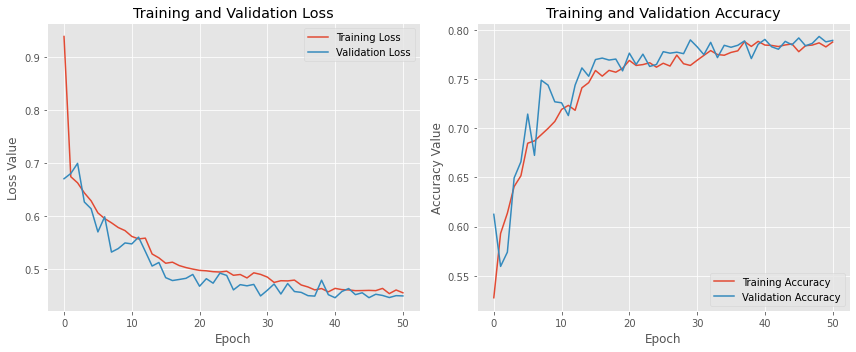

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.savefig('loss_acc v5.png')
plt.show()


In [24]:
Train.class_indices

{'cats': 0, 'dogs': 1}

In [33]:
def result(path,model):
    test_data= image.load_img(path, target_size=(64,64))
    test_data= image.img_to_array(test_data)
    test_data= np.expand_dims(test_data, axis=0)
    return "Dog" if model.predict(test_data)[0]==1 else "Cat"

In [34]:

result('dataset/single_prediction/cat_or_dog_1.jpg',cnn)

1/1 [==============================] - 0s 30ms/step


'Dog'

In [35]:
result('dataset/single_prediction/cat_or_dog_2.jpg',cnn)

1/1 [==============================] - 0s 32ms/step


'Cat'

In [36]:
result('dataset/test/cats/cat.4031.jpg',cnn)

1/1 [==============================] - 0s 28ms/step


'Cat'

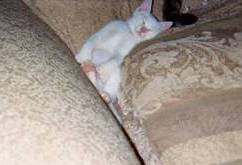

In [37]:
#Correct prediction even when the cat is not clearly visible
image.load_img('dataset/test/cats/cat.4031.jpg')

In [39]:
#Checking the final loss & accuracy of the model
prediction=ImageDataGenerator(rescale=1./255)
prediction=prediction.flow_from_directory('dataset/test',target_size=(64,64),batch_size=32, class_mode='binary',shuffle=False) 

Found 2000 images belonging to 2 classes.


In [40]:
loss,accuracy=cnn.evaluate(prediction,steps=len(prediction))
print("Loss: ",loss,"\nAccuracy: ",accuracy*100,"%")

63/63 [==============================] - 5s 77ms/step - loss: 0.4496 - accuracy: 0.7895
Loss:  0.4495640695095062 
Accuracy:  78.94999980926514 %


<h3>VGG16 Model</h3>

In [43]:

# Load the pre-trained VGG16 model
base_model = VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freezing some layers so that there weights won't be updated
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Check which layers are trainable
for layer in base_model.layers:
    print(layer, layer.trainable)

# Create a custom classification head
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


<keras.src.engine.input_layer.InputLayer object at 0x0000014FD28468E0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000014FD2846700> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000014FD5362730> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000014FD2196F70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000014FD52C1850> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000014FD529A460> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000014FD285FC10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000014FCB229970> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000014FD284E3D0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000014FD284E160> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000014FD286C5E0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000014FD286C250> False


<h4> Training the VGG16</h4>

In [44]:
history1=model.fit(x=Train,validation_data=Test,epochs=70,callbacks=[early_stopping,checkpoint,reduce_lr],verbose=1)

Epoch 1/70
250/250 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.7170
Epoch 1: val_loss improved from 0.44614 to 0.41763, saving model to best_model v5.h5


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 241s 959ms/step - loss: 0.5542 - accuracy: 0.7170 - val_loss: 0.4176 - val_accuracy: 0.7995 - lr: 1.0000e-04
Epoch 2/70
250/250 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.7741
Epoch 2: val_loss did not improve from 0.41763
250/250 [==============================] - 247s 987ms/step - loss: 0.4701 - accuracy: 0.7741 - val_loss: 0.4714 - val_accuracy: 0.7665 - lr: 1.0000e-04
Epoch 3/70
250/250 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.7905
Epoch 3: val_loss improved from 0.41763 to 0.39291, saving model to best_model v5.h5
250/250 [==============================] - 233s 932ms/step - loss: 0.4389 - accuracy: 0.7905 - val_loss: 0.3929 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 4/70
250/250 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8025
Epoch 4: val_loss did not improve from 0.39291
250/250 [==============================] - 215s 861ms/step - loss: 0.4194 - a

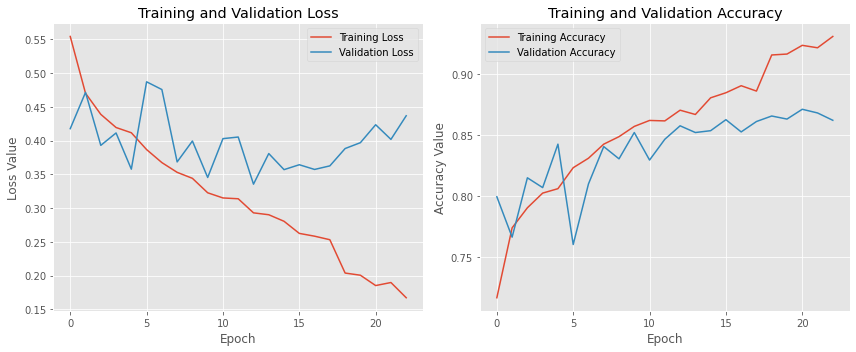

In [46]:
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# If you have also set metrics=['accuracy'] in the model compilation step
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

plt.figure(figsize=(12, 5))

# Plotting loss & accuracy
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.savefig('loss_acc VGG16.png')
plt.show()


In [ ]:
'''
Though VGG16 tends to overfit on our dataset, it still provides us with constant validation accuracy.
And the validation accuracy of our VGG16 model(0.86) is better than our traditional CNN model.
'''

In [59]:
loss,accuracy=model.evaluate(prediction,steps=len(prediction))
print("Loss: ",loss,"\nAccuracy: ",accuracy*100,"%")

63/63 [==============================] - 22s 342ms/step - loss: 0.4368 - accuracy: 0.8620
Loss:  0.43676766753196716 
Accuracy:  86.19999885559082 %


In [66]:
#Where the model is getting wrong?
result('dataset/test/cats/cat.4085.jpg',model)

1/1 [==============================] - 0s 96ms/step


'Dog'

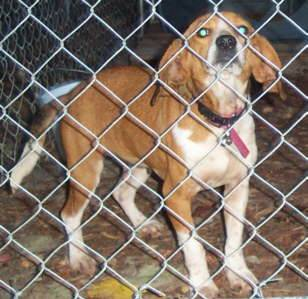

In [65]:
image.load_img('dataset/test/cats/cat.4085.jpg')
#I later discovered there have been some wrong labelled images in the dataset. One reason in the descrease of the accuracy, as the model correctly 
#predicts but the label with the image is of cat.

In [68]:
result('dataset/test/cats/cat.4104.jpg',model)

1/1 [==============================] - 0s 51ms/step


'Dog'

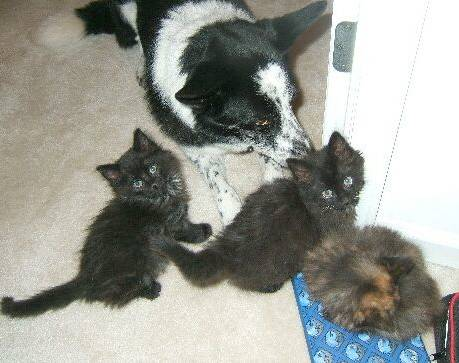

In [69]:
image.load_img('dataset/test/cats/cat.4104.jpg')
#The model isn't wrong either as it detects the dog more in a image containing both.

In [72]:
result('dataset/test/cats/cat.4190.jpg',model)

1/1 [==============================] - 0s 54ms/step


'Dog'

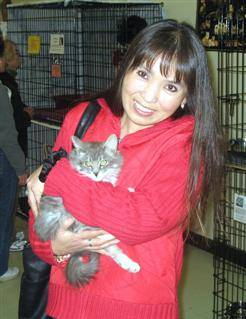

In [73]:
image.load_img('dataset/test/cats/cat.4190.jpg')
#Also issues like these where the animalis not visible at all

In [77]:
result('dataset/test/cats/cat.4321.jpg',model)

1/1 [==============================] - 0s 43ms/step


'Cat'